In [77]:
from openai import OpenAI
import pickle


In [78]:
train_path = "/Users/vishesh/projects/Pricer/data/balanced/train.pkl"
test_path = "/Users/vishesh/projects/Pricer/data/balanced/test.pkl"
val_path = "/Users/vishesh/projects/Pricer/data/balanced/val.pkl"
with open(train_path , 'rb') as f:
    train = pickle.load(f)
with open(test_path , 'rb') as f:
    test = pickle.load(f)
with open(val_path , 'rb') as f:
    validation = pickle.load(f)

In [79]:
fine_tune_train = train[:200]
fine_tune_validation = validation[:50]

### 1.Data Preparation in JSONL (JSON Lines) 
- Preparing the data in jsonl format and uploading to OpenAI

In [94]:
#message template for openai in a function - prompting 
def message_for(item):
    system_message = "You estimate price of items and Reply only with the price , no explanation"
    #removing the extra in the original test prompt and adding it in the system and assistant prompt for better efficiancy 
    user_prompt = item['test_prompt']
    return [
        {"role":"system" , "content":system_message},
        {"role":"user" , "content":user_prompt},
        {"role":"assistant" , "content":f"Price is ${item['price']:.2f}"}
    ]

In [80]:
message_for(test.iloc[3])

{'messages': [{'role': 'system',
   'content': 'You estimate price of items and Reply only with the price, no explanation'},
  {'role': 'user',
   'content': 'How much does this cost to the nearest dollar?\n\nVangoa Snare Drum Kit, Marching Snare Drum, 14 x 5.5 with 10mm Padding Carry Bag, 5A DrumSticks, Speed-up Drum Key, Strap, Drum Mute Pad\n✅ Wood Shell Maple shell has good durability, resonance, and sound quality. The clear, balanced and warmer sound makes it highly versatile. 20 strands snare wires are sensitive to respond to the slightest brush movement ✅ Good Sound 9 ply maple shell is solid to resist warping and affects the readily energy is transferred from the heads to the shell, offers rich and warm wood tone and good sound projection ✅ 45° roundover Edges 45° round-over bearing edge promotes finely balanced, has amazing clarity without premature delay, which results in a classic vintage sound and brighter sound. Less attack, fewer overtones, and less definition ✅\n\nPrice 

In [81]:
import json

In [97]:
def make_jsonl(items):
    result = ""
    for _ , item in items.iterrows():
        messages = message_for(item)
        result += json.dumps(messages) + '\n'  # ✅ Wrap in object
    return result.strip()

In [93]:
print(make_jsonl(train[:3]))

{"messages": {"messages": [{"role": "system", "content": "You estimate price of items and Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost to the nearest dollar?\n\nNylon Starter Cord - 1/8 Inch x 250 Feet - Replacement Rope for Recoil Starters\nHard Lay Nylon - tight slick weave makes it an excellent cordage to work with. 100% Nylon Fiber - low-stretch braided nylon cord with no mix of other materials. Made in the USA - top notch rope for those occasions when you need high resistance to abrasion and other harsh exposure elements such as oil and grease. Perfect Starter Rope - high quality perfect replacement cord for many recoil starters. Rugged and Holds Up Well - breaking strength of 400 lbs; working load 80 lbs. Material Nylon, Brand GOLBERG G, Style Durable, Line Weight 400 pound, Tensile Strength 400 Pounds, Length 3000 Inches, Manufacturer GOLBERG G, Part Weight 1.54 pounds, model number Size 1/\n\nPrice is $"}, {"role": "assistant

In [83]:
def write_jsonl(items,filename):
    with open(filename , 'w') as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [ ]:
write_jsonl(fine_tune_train,"fine_tune_train.jsonl")
write_jsonl(fine_tune_validation,"fine_tune_validation.jsonl")

In [84]:
from dotenv import load_dotenv
import os


In [85]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai = OpenAI()

In [ ]:
with open("fine_tune_train.jsonl" , 'rb') as f:
    train_file = openai.files.create(file = f , purpose='fine-tune')

with open("fine_tune_validation.jsonl" , 'rb') as f:
    validation_file = openai.files.create(file = f , purpose='fine-tune')

In [ ]:
train_file.id


In [ ]:
validation_file.id


In [ ]:
wandb_integration = {"type":"wandb", "wandb":{"project":"product_pricer"}}

In [ ]:
openai.fine_tuning.jobs.create(
    training_file = train_file.id ,
    validation_file = validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

### Fine-tuned Model Testing


In [86]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [87]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [88]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:COjM1CnN'

In [89]:
import re
def extract_price(text):
    text = text.replace("$","").replace(",","")
    match = re.search(r'[-+]?\d*\.\d+|\d+' , text)
    return float(match.group()) if match else 0

In [95]:
def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model = fine_tuned_model_name , 
        messages = message_for(item) ,
        seed = 42 , 
        max_tokens = 7
    )
    reply = response.choices[0].message.content
    return extract_price(reply)

In [99]:
print(test['price'].iloc[4])
print(gpt_fine_tuned(test.iloc[4]))

45.99
45.99


In [100]:
print(test['test_prompt'].iloc[0])

How much does this cost to the nearest dollar?

ZLINE 30 in. Wooden Wall Mount Range Hood in Cottage White - Includes Motor
The ZLINE KPTT wall mount wooden range hood designed to be both elegant and powerful, featuring the industry's only lifetime warranty motor. The hand-finished painted cottage white wood is made from solid pine with a stainless steel inner frame, making it both durable and long-lasting. This durable construction, along with ZLINE's lifetime warranty on the motor, guarantees a range hood that will last for a lifetime. This classic wooden hood contains many modern features, such as Hand-carved, hand-finished wood; Dishwasher-safe stainless steel baffle filters; Built-in LED lighting; High performance motor with speeds up to 400 CFM. All ZLINE range hoods come equipped with everything needed to easily install and use, including a 24 inch chimney with crown molding. This hood will fit most ceilings up

Price is $


In [102]:
# importing advanced tester file from 
import sys
sys.path.append('..')
from src.advanced_tester import Tester

Correct Predictions: 100%|██████████| 175/1757:02<00:00]
Testing Progress: 100%|██████████| 250/250 [07:02<00:00]



Test Results Summary:
Total Predictions: 250
Correct (Green): 240 (96.0%)
Close (Orange): 7 (2.8%)
Wrong (Red): 3 (1.2%)
Average Error: $7.55
RMSLE: 0.27


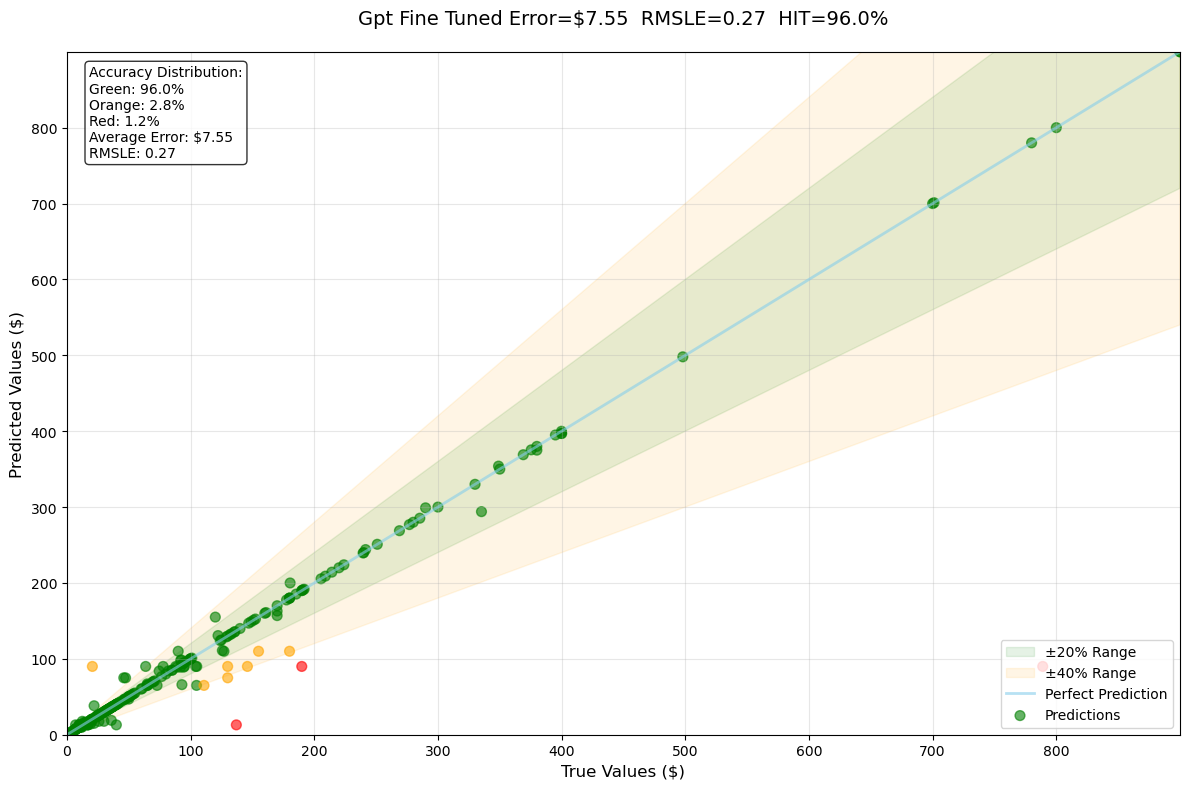

In [103]:
Tester.test(gpt_fine_tuned,test)

In [107]:
print(test['test_prompt'].iloc[1])


How much does this cost to the nearest dollar?

Rise of Nations Rise of Legends
Journey to the land of Aio, a world embroiled in an epic battle between the forces of Magic and Technology. Fight through towering cities, flame-swept deserts and brutal ice plains in battles filled with mystic creatures, impossible machines, and stunning acts of magic. In this sequel to Microsoft’s award-winning strategy game, Rise of Nations, you will guide a young inventor's struggle to unravel his world's ancient past and unite its people against an unimaginable threat. Multiplayer carnage reigns supreme when you take the war online. Command mystic creatures and impossible machines as you enter a world unlike any you’ve ever seen – a world of heroes, monsters, loyalty and betrayal. Release date February 8, 2010, Rank Video Games Linux Games 34, PC-compatible Games 5676, Pricing The striketh

Price is $
